In [1]:
import os
import numpy as np
import pandas as pd
import time
import json
import requests
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)


In [2]:
### Load sequences and annotations for disprot

def get_sequences(fastadir=None, fastafile=None):
    sequences = []
    if fastadir is None and fastafile is None:
        print("No fasta dir or file")
        raise
    if fastadir is not None and fastafile is not None:
        print("Choose one, fasta dir or multi fasta filr")
        raise
    # check for a directory with individual fasta files
    # or a multi fasta file
    if fastadir is not None:
        fastafiles = os.listdir(fastadir)
        for f in fastafiles:
            counter = 0
            for record in SeqIO.parse(os.path.join(fastadir, f), "fasta"):
                sequences.append(record)
                counter += 1
                if counter > 1:
                    print("More than one fasta record?", f)
                    raise
    elif fastafile is not None:
        for record in SeqIO.parse(fastafile, "fasta"):
            sequences.append(record)
    return sequences

# Disprot
# embeddir="/data/franco/disorder_flavours/testset/" #"/data/franco/datasets/prot_embedding_weights/disprot/halft5/"
fasta_dir = "../datasets/disprot/fasta/" #"/data/franco/datasets/disprot/fasta/"
counter = 0

# find annotation for each sequence
annotfile = "../datasets/disprot/DisProt_release_2022_06_reformat_annot.fasta" #/data/franco/datasets/disprot/
annotdir  = None
annots    = get_sequences(fastadir=annotdir, fastafile=annotfile)
sequences = get_sequences(fastadir=fasta_dir, fastafile=None)

In [3]:
### Make sure seq and annotations length match, and embed test proteins
annot_dict = dict()
for record in annots:
    if "|" in record.name:
        name = record.name.split("|")[1].strip()
    else:
        name = record.name.split()[0].strip()
        if name == "":
            print("Name is empty",record.name)
    annot_dict[name] = str(record.seq)
    
msequences  = list()
mannots     = list()
uniprots    = list()
counter = 0
maxlen = 1022
for s in sequences:
    if "|" in s.name:
        uniprot_id = s.name.split("|")[1].strip()
    else:
        uniprot_id = s.name.split()[0].strip()
    print(uniprot_id)
    aa_sequence = str(s.seq).upper()
    if len(aa_sequence) == len(annot_dict[uniprot_id]):
        if len(aa_sequence) <= maxlen:
            uniprots.append(uniprot_id)
            msequences.append(aa_sequence)
            mannots.append(annot_dict[uniprot_id])
            counter += 1
        else:
            print(f"Seq length is {len(aa_sequence)} > {maxlen}")
    else:
        print("Seq length and annot do not match")
        print(len(annot_dict[uniprot_id]), uniprot_id, len(aa_sequence))
print(f"Loaded {counter} proteins")

P03347
P19793
P48439
P03265
P0CF51
P0ABJ3
P02511
Q9JIH2
Q5UPT2
Q15013
P78362
P63165
P08067
P09883
O43236
Q8IVH8
P0AES9
P78504
Seq length is 1218 > 1022
P49913
P04156
P28327
Q12142
P97784
P45523
O25010
P11409
D1A4G7
Seq length is 1315 > 1022
Q9ERE3
B0FRH7
P02655
P01009
Q9UKX7
P10415
Q15726
P03496
P10636-2
P02259
Q14019
P12956
Q96SD1
P18615
P02315
P0AD27
P35269
P20893
P00488
Q7X2A1
Seq length is 1889 > 1022
P04083
Q14449
P12464
P28583
P63159
Q87P35
P0CU51
P02640
P47093
Q9NQA5
P61765
Q5T1C6
P52945
P05055
O00522
F1QR43
P24864
Q9GZN7
P14907
P04147
Q10589
P04610
G5EFZ1
Q47184
P51123
Seq length is 2129 > 1022
Q9NQB0
P00734
P17870
P63241
P10175
P96884
E6PBU3
P51587
Seq length is 3418 > 1022
P04637
P00004
Q5SHN5
Q9JLC3
P58753
P01094
P0AFC3
Q39026
P00392
Q84852
Seq length is 1225 > 1022
P45985
P27392
F2Z293
Q9UM11
P04968
O95149
O53168
P01100
P22531
P51177
A6NF83
P0A9A6
P0DTH5
P9WNK3
O32728
P80870
Q6MRH6
Q62165
Q9BE39
Seq length is 1935 > 1022
P07749
P98066
P21447
Seq length is 1276 > 1022
F6IAY2

In [5]:
## Write fasta files for the dataset
with open("disprot_OK_fullset.fasta", 'w') as outstrm:
    for i, uniprot_id in enumerate(uniprots):
        outstrm.write(f">{uniprot_id}\n{msequences[i]}\n")

with open("disprot_OK_fullset_annotations.fasta", 'w') as outstrm:
    for i, uniprot_id in enumerate(uniprots):
        outstrm.write(f">{uniprot_id}\n{mannots[i]}\n")

In [14]:
with open("disprot_OK_fullset.uniprot_ids.txt", 'w') as outstrm:
    for u in uniprots:
        outstrm.write(f"{u}\n")

In [15]:
len(uniprots)

2145

In [5]:
## Download AlphaFold2 models for target uniprots from disprot

if not os.path.exists("AF"):
    os.makedirs("AF")
    
success_unipids = list()
failed_unipids = list()
for unip in uniprots:
    file = f"./AF/AF-{unip}-F1-model_v4.cif"
    if not os.path.exists(file):
        fileurl = f"https://alphafold.ebi.ac.uk/files/AF-{unip}-F1-model_v4.cif"
        #print(fileurl)
        #print(f"wget -O {file} {fileurl}")
        # # try:
        res = requests.get(f"https://alphafold.ebi.ac.uk/files/AF-{unip}-F1-model_v4.cif")
        if res.status_code == 200:
            print(unip)
            with open(file, 'w') as outfmt:
                outfmt.write(res.content.decode())
                success_unipids.append(unip)
        else:
            print(f"Failed to get AF2 model for {unip}")
            print(res)
            failed_unipids.append(unip)
    else:
        print(f"File exists: {unip}")

Failed to get AF2 model for P03347
<Response [404]>
P19793
P48439
Failed to get AF2 model for P03265
<Response [404]>
P0CF51
P0ABJ3
P02511
Q9JIH2
Failed to get AF2 model for Q5UPT2
<Response [404]>
Q15013
P78362
P63165
P08067
P09883
O43236
Q8IVH8
P0AES9
P49913
P04156
P28327
Q12142
P97784
P45523
O25010
P11409
Q9ERE3
B0FRH7
P02655
P01009
Q9UKX7
P10415
Q15726
Failed to get AF2 model for P03496
<Response [404]>
Failed to get AF2 model for P10636-2
<Response [404]>
P02259
Q14019
P12956
Q96SD1
P18615
P02315
P0AD27
P35269
Failed to get AF2 model for P20893
<Response [404]>
P00488
P04083
Q14449
P12464
P28583
P63159
Q87P35
P0CU51
P02640
P47093
Q9NQA5
P61765
Q5T1C6
P52945
P05055
O00522
F1QR43
P24864
Q9GZN7
P14907
P04147
Q10589
Failed to get AF2 model for P04610
<Response [404]>
G5EFZ1
Q47184
Q9NQB0
P00734
P17870
P63241
P10175
P96884
E6PBU3
P04637
P00004
Q5SHN5
Failed to get AF2 model for Q9JLC3
<Response [404]>
P58753
P01094
P0AFC3
Q39026
P00392
P45985
Failed to get AF2 model for P27392
<Respons

P77173
Q8ZKB0
Q9BTT0
Failed to get AF2 model for Q38151
<Response [404]>
Q03479
Q32NN2
O96017
P83731
P0C079
P17677
Q9VZU1
P33328
O88900
O60563
Q885L4
C4M7X2
P38936
P12357
P07476
P48539
Q12287
P49768
Q91ZW2
Q8ILA1
P09038
P50750
Q39532
Failed to get AF2 model for P12506
<Response [404]>
P49354
P23025
Q61937
Q9TY14
P42574
Q10Q08
Q09260
P9WKX3
P80644
P14448
Q8N884
P97303
Q9UBB5
P17109
P33322
Q09882
O23813
Failed to get AF2 model for P0DTC4
<Response [404]>
Failed to get AF2 model for Q9P2K3-3
<Response [404]>
P10163
P35813
P11632
Q9XES8
Q16143
Q3U4G3
P0AG16
Q01080
P22059
P46984
O14832
E2IHW6
Q9H875
Q13415
P17639
Q9JK66
Failed to get AF2 model for P36932
<Response [404]>
P26477
P9WHJ5
Failed to get AF2 model for Q0GBY3
<Response [404]>
Q16665
A0MHA3
Q8IU57
Q2GI62
O74774
P0DN86
P35236
P38516
P0A7L8
Q8T9B6
Q16630
Failed to get AF2 model for Q05127
<Response [404]>
Q07528
Q9L9I0
Q96B02
P37330
P0AD49
Q24570
Q5JH72
P55957
O43561
P30771
Q9UBU9
Q8RNT4
Q13148
P51965
Q01844
Q9XTN4
P49765
P05387
P077

Q9JI51
Q8GY31
Q9Y3B4
P07805
P01112
O43464
Q9Y239
P0A2N1
P10114
P32628
P0C0Y1
P21109
O28362
P68363
Q80VW5
Q68FT9
P55072
O95292
P21580
P0AFZ3
Q6NUK1
P0AB38
Q8N1Q8
Q8K4J6
P62696
P02283
P21583
Q9NJS1
P37727
Q9BXJ9
P30429
P04386
P39935
P42003
O43806
Q12483
Failed to get AF2 model for P0DTC3
<Response [404]>
Q9DDG2
O65934
O75475
P06239
P02545
Q9RSK0
P83917
P0ADC1
P62944
P30185
P42568
Q8R464
P22303
P14061
Q8H1D4
P05434
P13693
B7T1D7
P31109
Q97W59
P49841
P41780
P22868
Q9Y9L0
P41209
P05107
P09693
Q42512
P33905
O60508
Q9A8N4
O35613
P40999
O14214
P0DJ89
Q02554
Q02078
P27321
Q8IW19
P56287
Q96G97
P01137
Q7DB66
P47273
P35585
Q9DBG5
Q9NV23
Failed to get AF2 model for P0DOF3
<Response [404]>
O00299
Failed to get AF2 model for Q05128
<Response [404]>
A0R1T8
Q9RJY2
P42763
P46669
P36152
Q9BUH6
P0A7K2
P27682
P9WHN5
Failed to get AF2 model for Q00987-11
<Response [404]>
Q96EQ8
Q53FT3
P06149
Q02521
P81455
Q29983
P31087
O35484
Q8IVG9
Q9UJX2
Failed to get AF2 model for Q9IH62
<Response [404]>
Q9BVI0
P48788
Q9

In [8]:
print(len(success_unipids))
print(len(failed_unipids))

1960
185


In [9]:
from Bio.PDB.MMCIF2Dict import MMCIF2Dict

def parse_AF_CIF(file):
    # read in the CIF file.
    # file = "./AF/AF-P02686-F1-model_v4.cif"
    pdb_info = MMCIF2Dict(file)

    seq = pdb_info["_entity_poly.pdbx_seq_one_letter_code"][0].replace("\n", "")

    pLDDT_seq = pdb_info['_ma_qa_metric_local.label_seq_id']
    pLDDT = pdb_info['_ma_qa_metric_local.metric_value']

    dssp_type = pdb_info['_struct_conf.conf_type_id']
    dssp_beg  = pdb_info['_struct_conf.beg_label_seq_id']
    dssp_end  = pdb_info['_struct_conf.end_label_seq_id']
    
    seq_placeholder = ["-" for i in range(len(seq))]
    for i in range(len(dssp_type)):
        if dssp_type[i].startswith("HELX"):
            letter = "H"
            beg = int(dssp_beg[i])
            end = int(dssp_end[i])
            for j in range(beg-1, end):
                seq_placeholder[j] = letter
        if dssp_type[i].startswith("STRN"):
            letter = "B"
            beg = int(dssp_beg[i])
            end = int(dssp_end[i])
            for j in range(beg-1, end):
                seq_placeholder[j] = letter
    if len(seq) == len(pLDDT) and len(seq) == len(seq_placeholder):
        return seq, pLDDT, seq_placeholder
    else:
        raise

In [13]:
AF_dict = dict()

for i, unip in enumerate(success_unipids):
    file = f"./AF/AF-{unip}-F1-model_v4.cif"
    if os.path.exists(file):
        seq, pLDDT, dssp = parse_AF_CIF(file)
        AF_dict[unip] = dict()
        AF_dict[unip]["seq"] = seq
        AF_dict[unip]["pLDDT"] = pLDDT
        AF_dict[unip]["disorder"] = mannots[uniprots.index(unip)]
        AF_dict[unip]["ss"] = dssp
        if AF_dict[unip]["seq"] == msequences[uniprots.index(unip)]:
            if len(AF_dict[unip]["disorder"]) == len(AF_dict[unip]['seq']):
                print("OK", end=" ")
    else:
        print(f"\nNO FILE {unip}")

OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O

In [22]:
x = list()
cat = list()
for unip in AF_dict:
    x = x + AF_dict[unip]["pLDDT"]
    cat = cat + AF_dict[unip]["ss"]

In [23]:
x = np.array([float(i) for i in x])

In [24]:
ix_NA = [i for i in range(len(cat)) if cat[i] == "-"]
ix_H = [i for i in range(len(cat)) if cat[i] == "H"]
ix_B = [i for i in range(len(cat)) if cat[i] == "B"]

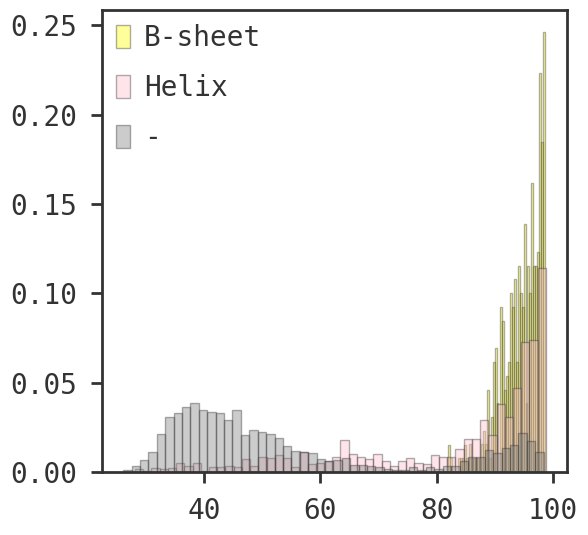

In [25]:
fig = plt.figure(figsize=(6,6), dpi=100)
ax = fig.add_subplot(111)
ax.hist(x[ix_B], bins=50, density=True, label="B-sheet", alpha=0.4, color='yellow')
ax.hist(x[ix_H], bins=50, density=True, label="Helix", alpha=0.4, color="pink")
ax.hist(x[ix_NA], bins=50, density=True, label="-", alpha=0.4, color='gray')
ax.legend()
plt.show()

In [26]:
with open("AF2_testset.json", 'w') as outfmt:
    json.dump(AF_dict, outfmt)
